In [2]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import numpy as np
import scipy.stats as stats
import time
import msprime
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
import pandas as pd
import pickle
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200


In [5]:
@np.vectorize
def bgs_rec(mu, s, r, L):
    return np.exp(-L * mu/(s*(1+(1-s)*r/s)**2))

## Noise in Pairwise Diversity

NOTE: out of date, see PDF notes

If we care about simulating some process and learning about some parameter from the observed $T_2$s (or some function of them), we need to get sense of the noise around $\pi$ and $T_2$. According to Tajima (1983), the variance in $\pi$ is:

$$\text{Var}(\pi) = \frac{n + 1}{3(n-1)} \theta + \frac{2(n^2 + n + 3)}{9n(n-1)}\theta^2$$

In the limit as $n \to \infty$, $\text{Var} = \frac{1}{9}(3 \theta + 2 \theta^2)$. The first term is the sampling variation, the second is the evolutionary variation. 

Note that if we use $\hat{B} = \pi / 4N$, $\text{Var}(\hat{B}) = \text{Var}(\pi)/4N^2$, which simplifies to (see Mathematica notebook):

$$\text{Var}(\hat{B}) = \frac{(n+1)}{3 (n-1)}\frac{\mu}{4N}+\frac{2 \left(n^2+n+3\right)}{9 (n-1) n}\mu^2 $$

$$\text{Var}(\hat{B}) = \frac{(n+1)}{3 (n-1)} \frac{\theta}{16N^2}  + \frac{2 \left(n^2+n+3\right)}{9 (n-1) n} \frac{\theta^2}{16N^2} $$


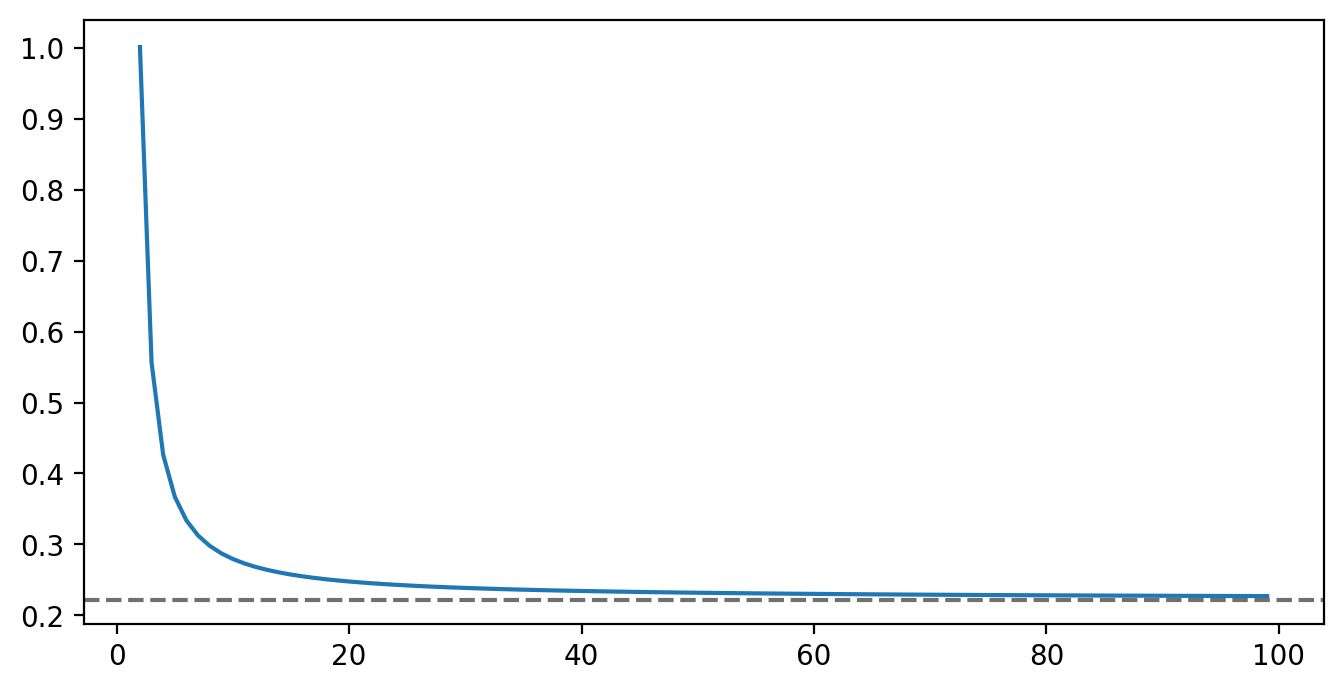

In [15]:
def B_var(n, N, theta):
    return (n+1)/(3*(n-1))*theta/(4*N**2) + 2*(n**2 + n + 3)/(9*n*(n-1)) *theta**2/(16*N**2)

def B_var_limit(N, mu=1):
    return (3*mu + 8*N*mu**2)/(36*N)

N = 1000

n = np.arange(2, 100)
plt.plot(n, B_var(n, N, 4000))
plt.axhline(B_var_limit(N), c='0.44', linestyle='dashed')


Does this theory check out against sims?

In [16]:
ns = [2, 4, 6, 10, 20, 30, 40] + np.arange(50, N, 100).tolist()

In [17]:
# simulate trees, return variance in Bhat for n=1000
y = [np.var([msprime.sim_ancestry(n, population_size=N).diversity(mode='branch')/(4*N) for _ in range(1000)]) for n in ns]

In [18]:
def taj83_var(n, theta):
    return (n+1)/(3*(n-1))*theta + 2*(n**2 + n + 3)/(9*n*(n-1)) * theta**2

Note: there appears to be a factor of two error somewhere here, but using the unscaled variance, it works.

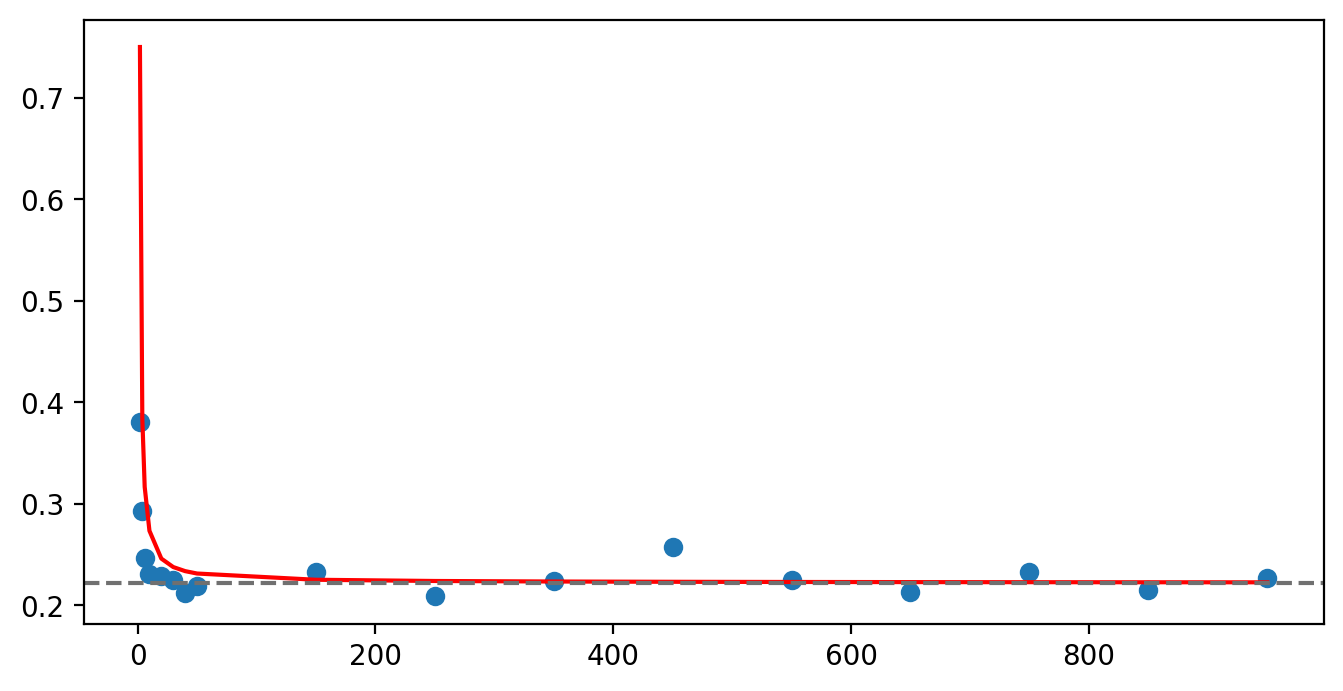

In [19]:
theta = 1/2

fig, ax = plt.subplots()
ax.scatter(ns, y)
ax.plot(ns, taj83_var(np.array(ns), theta), c='r')
ax.axhline(B_var_limit(N), linestyle='dashed', c='0.44')

Recall, branch-mode diversity returns $T_2$ in generation units, e.g. if $\mu = 1$, $E(\pi / 4N) = B$ which is 1 under neutrality:

In [20]:
np.mean([msprime.sim_ancestry(100, population_size=1000).diversity(mode='branch') for _ in range(1000)])

3987.6110581243765

In [21]:
np.mean([msprime.sim_ancestry(100, population_size=1000).diversity(mode='branch')/(4*N) for _ in range(1000)])

0.9822764711101729

In [22]:
np.var([msprime.sim_ancestry(100, population_size=1000).diversity(mode='branch')/(4*N) for _ in range(1000)])

0.22599702076018066

What's our theoretic lowest loss?

In [23]:
taj83_var(10000, 1)

0.5556666844462224

## Estimating B

If we're using branch statistics, our only source of variation is evolutionary variation. The pairwise coalescent time $T_2 \sim \text{Exp}(1/2N)$, such that $\text{E}(T_2) = 2N$ and $\text{Var}(T_2) = 4N^2$.

We imagine some fixed scalar $B$ rescales $N$; we wish to estimate this from $s$ observed trees using $\bar{B} = 1/s \sum_i^s T_2(i)/2N$. $\mathrm{E}(\bar{B}) = 2BN/2N = B$ so this is an unbiased estimator of $B$. $\mathrm{Var}(\bar{B}) = \frac{s \mathrm{Var}(T_2)}{4 s^2 N^2}  = \frac{4B^2N^2s}{4 s^2 N^2} = B^2/s$.

**Importantly**, note that this *ignores* the process noise due to selection; in reality $B$ itself is a random variable. However, selection may decrease $\mathrm{Var}(T_2)$.

Below I simulate this: each run draws $s$ sample trees, calculates $\hat{B}$ for each tree, and average them to get $\bar{B}$. I then consider the variance of these $\bar{B}$s.

In [24]:
N = 1000
B_array = np.linspace(0.1, 1, 10)
s_array = [2, 5, 10, 50, 100]
n_array = [N]
N_array = [N]
rep_array = np.arange(1000)
params = list(itertools.product(B_array, s_array, n_array, N_array, rep_array))
param_grid = np.array(params)

def runner(param):
    B, s, n, N, rep = param
    sims = np.array([msprime.sim_ancestry(n, population_size=B*N).diversity(mode='branch')/(4*N) for _ in range(s)])
    return sims.mean(), sims.var()

with Pool(70) as p:
    res = np.array(p.map(runner, params))

In [25]:
d = pd.DataFrame(np.concatenate((param_grid, res[:, 0][:, None]), axis=1))
d.columns = ['B', 's', 'n', 'N', 'rep', 'Bhat']
d.head()

,B,s,n,N,rep,Bhat
0,0.1,2.0,1000.0,1000.0,0.0,0.092833
1,0.1,2.0,1000.0,1000.0,1.0,0.159577
2,0.1,2.0,1000.0,1000.0,2.0,0.099733
3,0.1,2.0,1000.0,1000.0,3.0,0.050820
4,0.1,2.0,1000.0,1000.0,4.0,0.069263


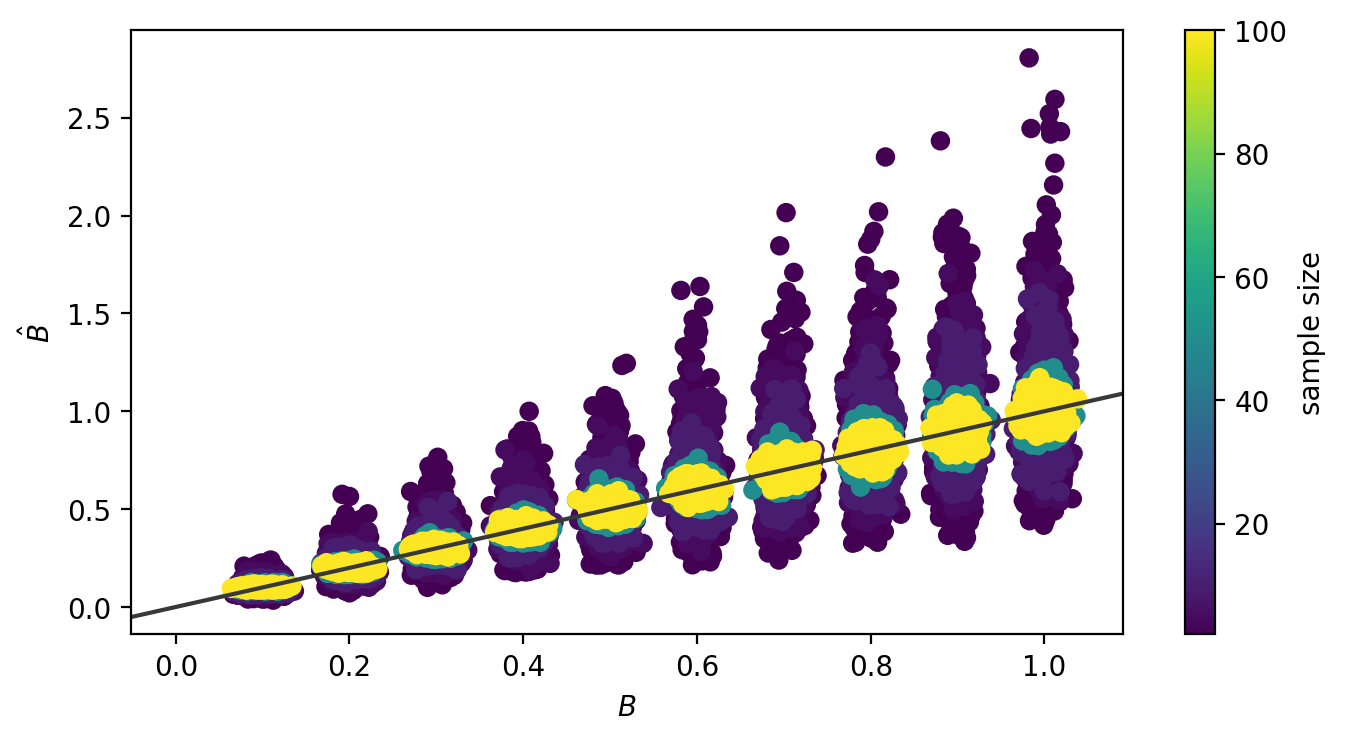

In [26]:
def jitter(x, var=0.01):
    return x + np.random.normal(0, var, len(x))

fig, ax = plt.subplots()
cax = ax.scatter(jitter(d['B']), d['Bhat'], c=d['s'], alpha=1)
ax.axline((0, 0), slope=1, c='0.22')
ax.set_xlabel('$B$')
ax.set_ylabel('$\hat{B}$')
plt.colorbar(cax, label='sample size')

In [27]:
ds = d.groupby(['B', 's', 'n', 'N']).agg([np.mean, np.var]).reset_index()
ds.columns = ["_".join(x) if len(x[1]) > 0 else x[0] for x in ds.columns]
ds.head()

,B,s,n,N,rep_mean,rep_var,Bhat_mean,Bhat_var
0,0.1,2.0,1000.0,1000.0,499.5,83416.666667,0.099194,0.001064
1,0.1,5.0,1000.0,1000.0,499.5,83416.666667,0.099355,0.000474
2,0.1,10.0,1000.0,1000.0,499.5,83416.666667,0.100059,0.000226
3,0.1,50.0,1000.0,1000.0,499.5,83416.666667,0.100140,0.000048
4,0.1,100.0,1000.0,1000.0,499.5,83416.666667,0.100006,0.000023


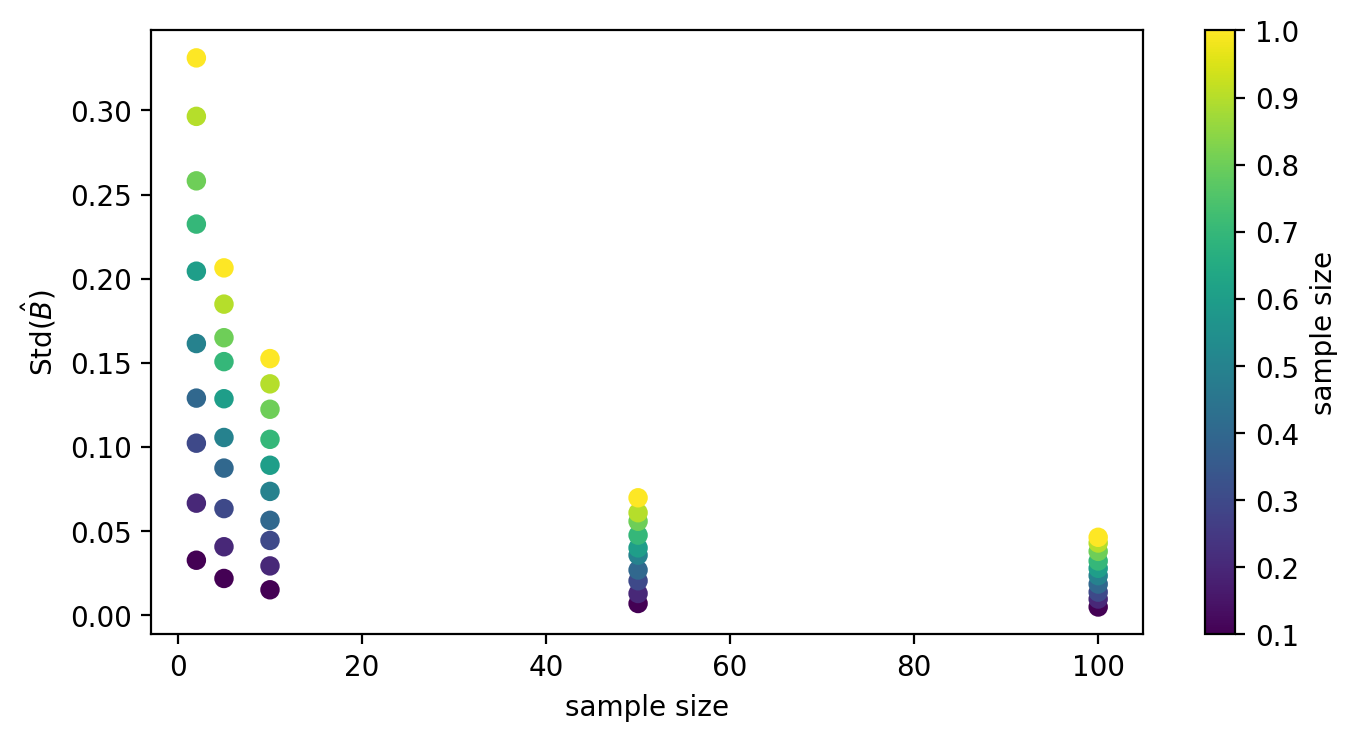

In [28]:
fig, ax = plt.subplots()
cax = ax.scatter(ds['s'], np.sqrt(ds['Bhat_var']), c=ds['B'])
ax.set_ylabel("$\mathrm{Std}(\hat{B})$")
ax.set_xlabel("sample size")
plt.colorbar(cax, label='sample size')

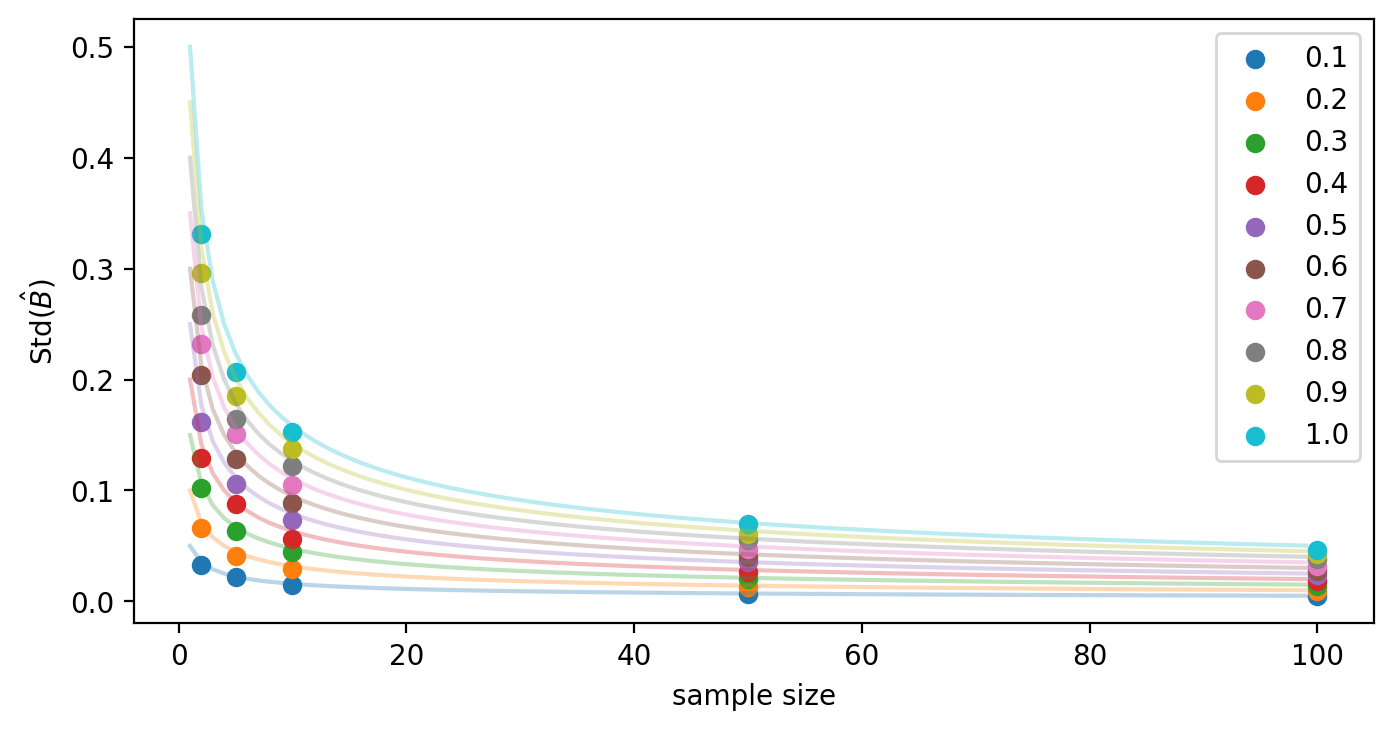

In [29]:
fig, ax = plt.subplots()
sx = np.arange(1, 100)
for b in B_array:
    dx = ds.loc[ds['B'] == b]
    c = ax.scatter(dx['s'], np.sqrt(dx['Bhat_var']), label=np.round(b, 2))
    ax.plot(sx, b*np.sqrt(0.25/sx), alpha=0.3)
ax.set_ylabel("$\mathrm{Std}(\hat{B})$")
ax.set_xlabel("sample size")
ax.legend()

Note that our theory works well, even though we're not conditioning on genealogies, but just imagining averaging over independent coalescent pairs to get $T_2$. This is because as the first section showed, the vast majority of the noise is from the evolutionary process itself.